#### based on Fig. 1 from Shipway & Hill 2012 (Q. J. Royal Meteo. Soc. 138)  "_Diagnosis of systematic differences between multiple parametrizations of warm rain microphysics using a kinematic framework_"   
https://doi.org/10.1002/qj.1913

**NOTES**: 
- constant momentum profile rather than constant velocity profile is used herein
- enabling precipitation interpretted as turning on sedimentation and collisions
- pressure at z=0 not given in the paper, assumed (see settings.py)
- domain extended below z=0 to mimic particle inflow

In [1]:
from settings import Settings 
from simulation import Simulation
from plot import plot
import numpy as np
import xarray
from tqdm import tqdm

from PySDM import Formulae
from PySDM.initialisation.spectra import Lognormal
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/impl_numba/conf.py:19: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


In [2]:
common_params = {
    "n_sd_per_mode": (128, 128),
    "aerosol_modes_by_kappa": {
            .54: Lognormal(
                        norm_factor= 50 / si.cm ** 3,
                        m_mode=40 * si.nm,
                        s_geom=1.4
                ),
            .85: Lognormal(
                    norm_factor= 10/ si.cm ** 3,
                    m_mode= 60 * si.nm,
                    s_geom= 1.2
                )
            },
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 990 * si.hPa
}
sav_flag= False

In [3]:
output = {}
settings = {}
simulation = {}
rain_xarr = {}
n_runs= 5

for r_id in tqdm(range(n_runs)):
    for rho_times_w in (
        2 * si.kg/si.m**3 * si.m/si.s,
        3 * si.kg/si.m**3 * si.m/si.s
    ):
        key = f"rhow={rho_times_w}_run={r_id}"
        settings[key] = Settings(
            **common_params,
            formulae= Formulae(seed= np.random.randint(1000)),
            rho_times_w_1=rho_times_w,
            precip= True
            )
        simulation[key] = Simulation(settings[key])
        output[key] = simulation[key].run().products
            
        rain_xarr[key]= xarray.DataArray(data= output[key]['rain water mixing ratio'],
                            dims=["z", "t"],
                            coords=dict(
                                t=(["t"], output[key]['t'],),
                                z=(["z"], output[key]['z'],),)
                            )
if sav_flag:
    rain_xarr.to_netcdf("../../sav_files/rwmr_" + key + "_n1_50_n2_1000.nc")

  0%|          | 0/5 [00:00<?, ?it/s]<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 20%|██        | 1/5 [01:04<04:18, 64.65s/it]<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 40%|████      | 2/5 [01:38<02:20, 46.73s/it]<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 60%|██████    | 3/5 [02:12<01:21, 40.90s/it]<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 80%|████████  | 4/5 [02:47<00:38, 38.29s/it]<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_

In [13]:
surface_rain= xarray.concat([rain_xarr["rhow=2.0_run=%d"%i] for i in range(n_runs)], dim="run")
surface_rain= surface_rain.assign_coords(run=range(n_runs))

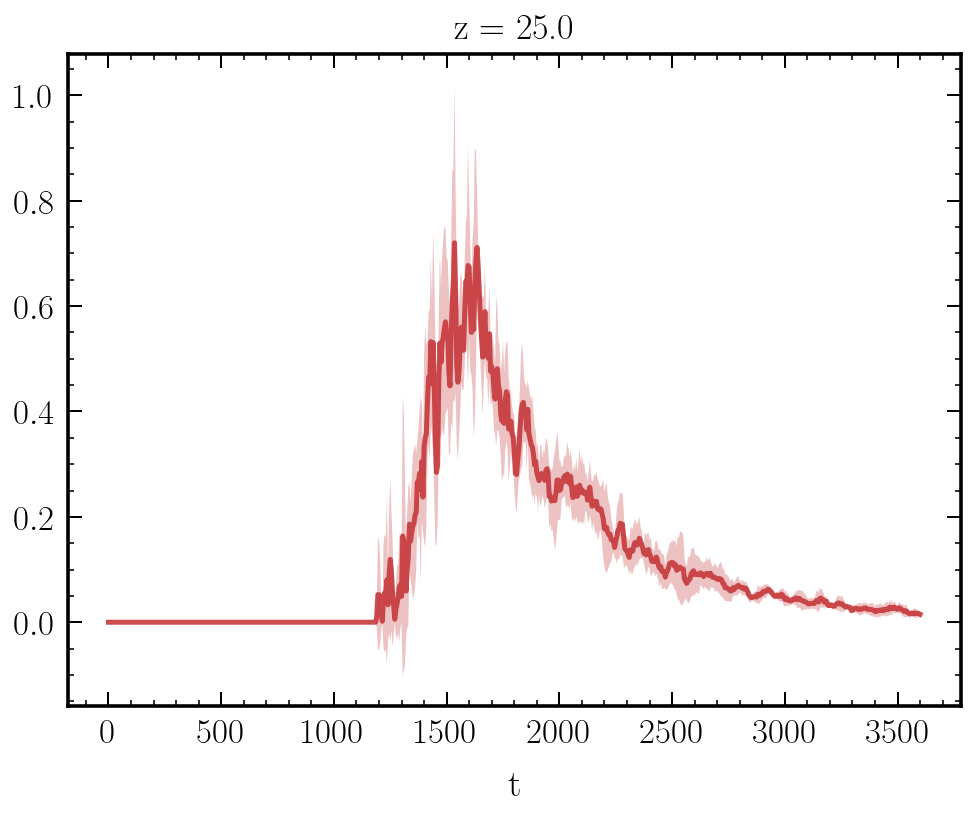

In [17]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
surface_rain.sel(z= 25).mean(dim= "run").plot(ax= ax)
ax.fill_between(surface_rain.t, surface_rain.sel(z= 25).mean(dim= "run") + surface_rain.sel(z= 25).std(dim= "run"), \
                                        surface_rain.sel(z= 25).mean(dim= "run") - surface_rain.sel(z= 25).std(dim= "run"), alpha= 0.3)

In [95]:
from PySDM.initialisation.sampling import spatial_sampling
from PySDM.backends import CPU

In [96]:
spatial_discretisation= spatial_sampling.Pseudorandom()

In [100]:
positions= spatial_discretisation.sample(
                backend= CPU(formulae= settings['rhow=2.0_p=True'].formulae),
                grid= simulation['rhow=2.0_p=True'].mesh.grid,
                n_sd= simulation['rhow=2.0_p=True'].particulator.n_sd,
                z_part= (0.25, 0.5)
            )

In [102]:
positions.max()

35.99983179661609

In [103]:
backend= CPU(formulae= settings['rhow=2.0_p=True'].formulae)
n_elements= simulation['rhow=2.0_p=True'].particulator.n_sd

storage = backend.Storage.empty(n_elements, dtype=float)
backend.Random(seed=backend.formulae.seed, size=n_elements)(storage)
positions = storage.to_ndarray().reshape(1, n_elements)

In [104]:
positions

array([[0.44457149, 0.9994728 , 0.77154317, ..., 0.23079577, 0.03110636,
        0.48882759]])

In [65]:
simulation['rhow=2.0_p=True'].__dict__.keys()

dict_keys(['nt', 'z0', 'save_spec_and_attr_times', 'number_of_bins', 'particulator', 'output_attributes', 'output_products', 'builder', 'mesh', 'env', 'mpdata', 'g_factor_vec', 'products', 'attributes'])

In [74]:
simulation['rhow=2.0_p=True'].attributes['cell id'].max(), simulation['rhow=2.0_p=True'].attributes['cell id'].min()

(72, 0)

In [75]:
simulation['rhow=3.0_p=True'].attributes['cell id'].max(), simulation['rhow=3.0_p=True'].attributes['cell id'].min()

(78, 0)

In [83]:
_, count_arr= np.unique(simulation['rhow=3.0_p=True'].attributes['cell id'], return_counts=True)
count_arr

array([251, 236, 256, 253, 264, 230, 229, 235, 245, 260, 252, 282, 249,
       272, 244, 233, 265, 267, 224, 264, 254, 251, 271, 249, 256, 281,
       258, 270, 290, 245, 274, 280, 250, 256, 244, 272, 290, 252, 268,
       241, 246, 249, 258, 265, 247, 266, 255, 256, 233, 271, 254, 240,
       247, 257, 258, 255, 274, 251, 274, 256, 282, 244, 244, 234, 261,
       253, 286, 252, 225, 273, 230, 244, 266, 244, 265, 258, 277, 260,
       251])

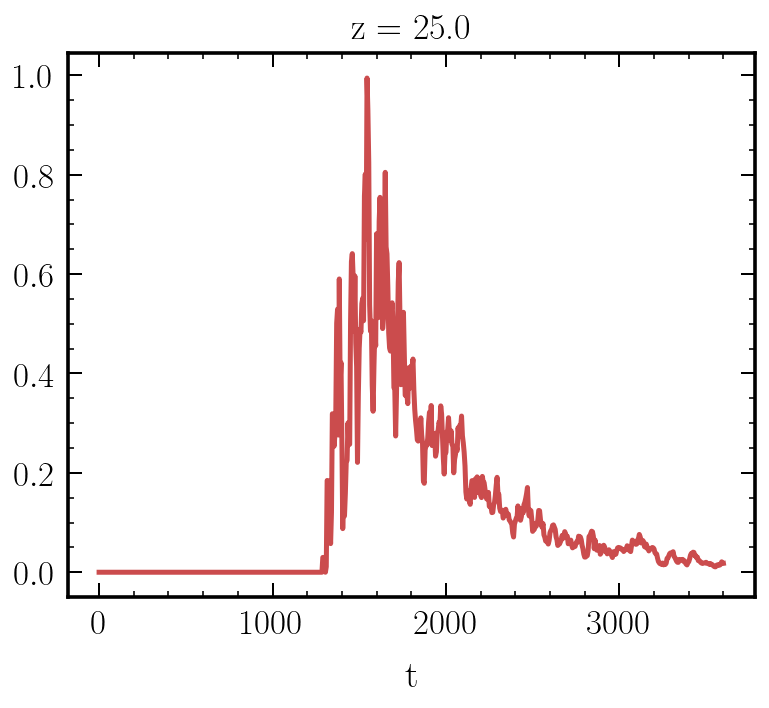

In [4]:
rain_xarr['rhow=2.0_p=True'].sel(z=25).plot()

In [5]:
np.sum(rain_xarr['rhow=2.0_p=True'].sel(z=25))

<xarray.DataArray ()>
array(82.45345849)
Coordinates:
    z        float64 25.0

In [8]:
run_1= rain_xarr['rhow=2.0_p=True'].sel(z=25)

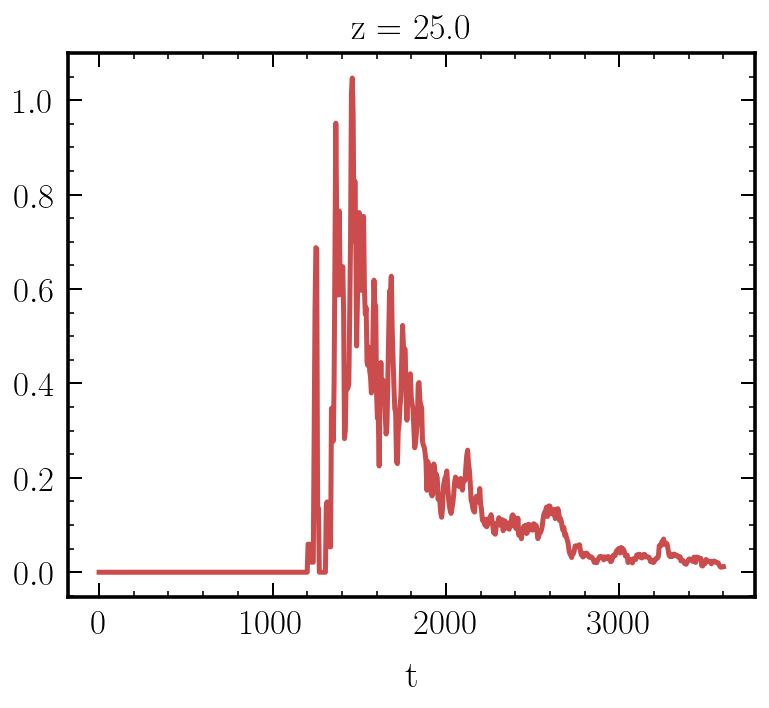

In [9]:
run_1.plot()

In [10]:
run_1.sum()

<xarray.DataArray ()>
array(82.63202697)
Coordinates:
    z        float64 25.0

## Plotting

In [5]:
rain_xarr_rhow2_bkg= xarray.open_dataarray("../../sav_files/rwmr_rhow=2.0_p=True_n1_50.nc")
rain_xarr_rhow2_seed= xarray.open_dataarray("../../sav_files/rwmr_rhow=2.0_p=True_n1_50_n2_100.nc")
rain_xarr_rhow3_bkg= xarray.open_dataarray("../../sav_files/rwmr_rhow=3.0_p=True_n1_50.nc")
rain_xarr_rhow3_seed= xarray.open_dataarray("../../sav_files/rwmr_rhow=3.0_p=True_n1_50_n2_100.nc")
#rain_xarr_rhow2_seed_low= xarray.open_dataarray("../../sav_files/rwmr_rhow=2.0_p=True_n1_50_n2_50.nc")
rain_xarr_rhow2_seed_high= xarray.open_dataarray("../../sav_files/rwmr_rhow=2.0_p=True_n1_50_n2_1000.nc")
rain_xarr_rhow3_seed_high= xarray.open_dataarray("../../sav_files/rwmr_rhow=3.0_p=True_n1_50_n2_1000.nc")

In [10]:
np.sum(rain_xarr_rhow2_bkg.sel(z= 25).values), np.sum(rain_xarr_rhow2_seed_high.sel(z= 25).values)

(86.39757742759123, 69.01083927082759)

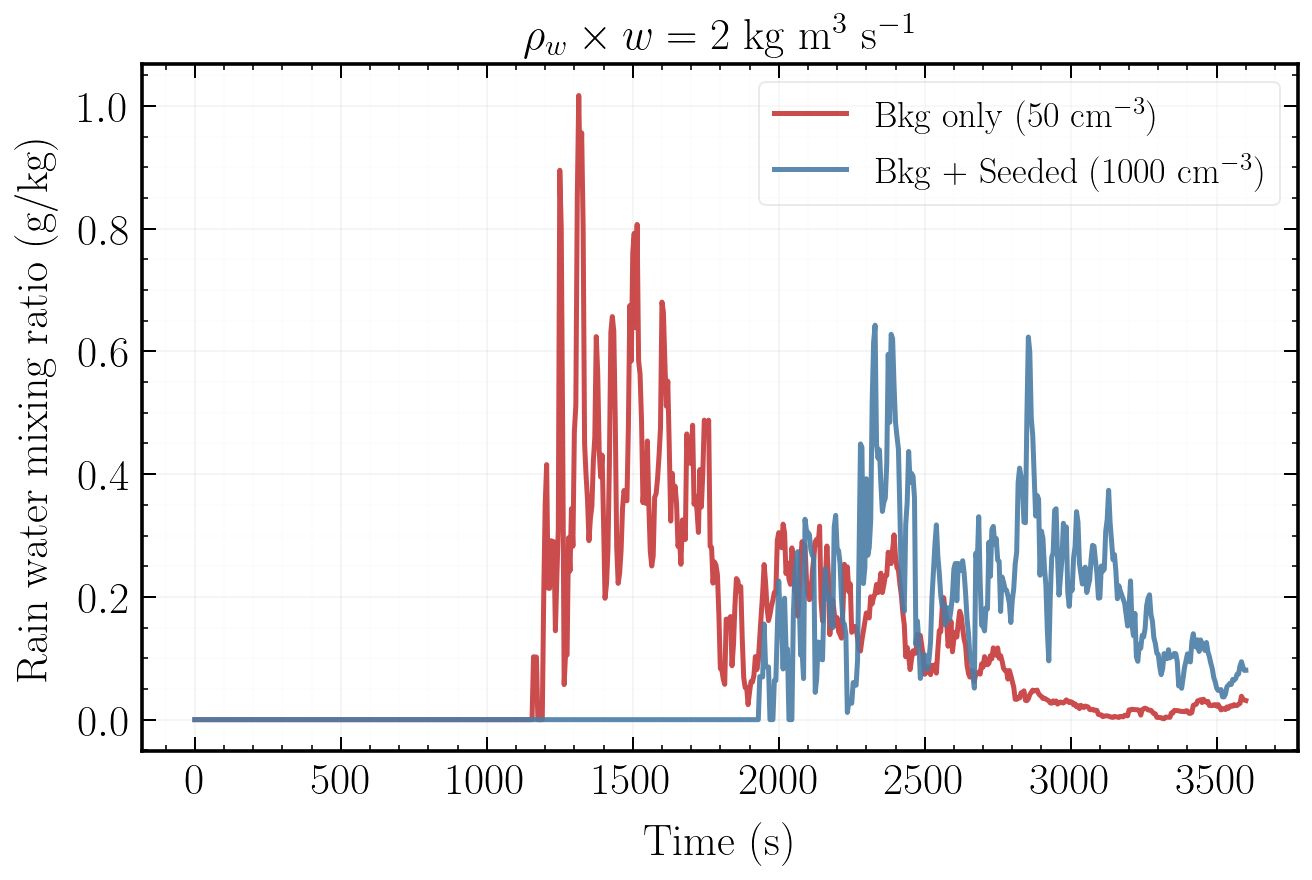

In [11]:
fig, ax= plt.subplots(1, 1, figsize= (9, 6) , constrained_layout= True)

ax.plot(rain_xarr_rhow2_bkg['t'], rain_xarr_rhow2_bkg.sel(z= 25).values, label= r'Bkg only (50 cm$^{-3}$)')
ax.plot(rain_xarr_rhow2_seed['t'], rain_xarr_rhow2_seed_high.sel(z= 25).values, label= r'Bkg + Seeded (1000 cm$^{-3}$)')
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Rain water mixing ratio (g/kg)', fontsize= 22);
ax.legend(loc= 'upper right', frameon= True, fontsize= 18);

ax.set_title(r'$\rho_w \times w = 2$ kg m$^{3}$ s$^{-1}$', fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#ax[0].text(0.18, 0.8, r'$r = %.2f$'%, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
#            transform=ax[0].transAxes)
plt.savefig('../../plots/rwmr_rhow=2.0_n1_50_n2_1000.pdf', bbox_inches='tight', dpi= 300);

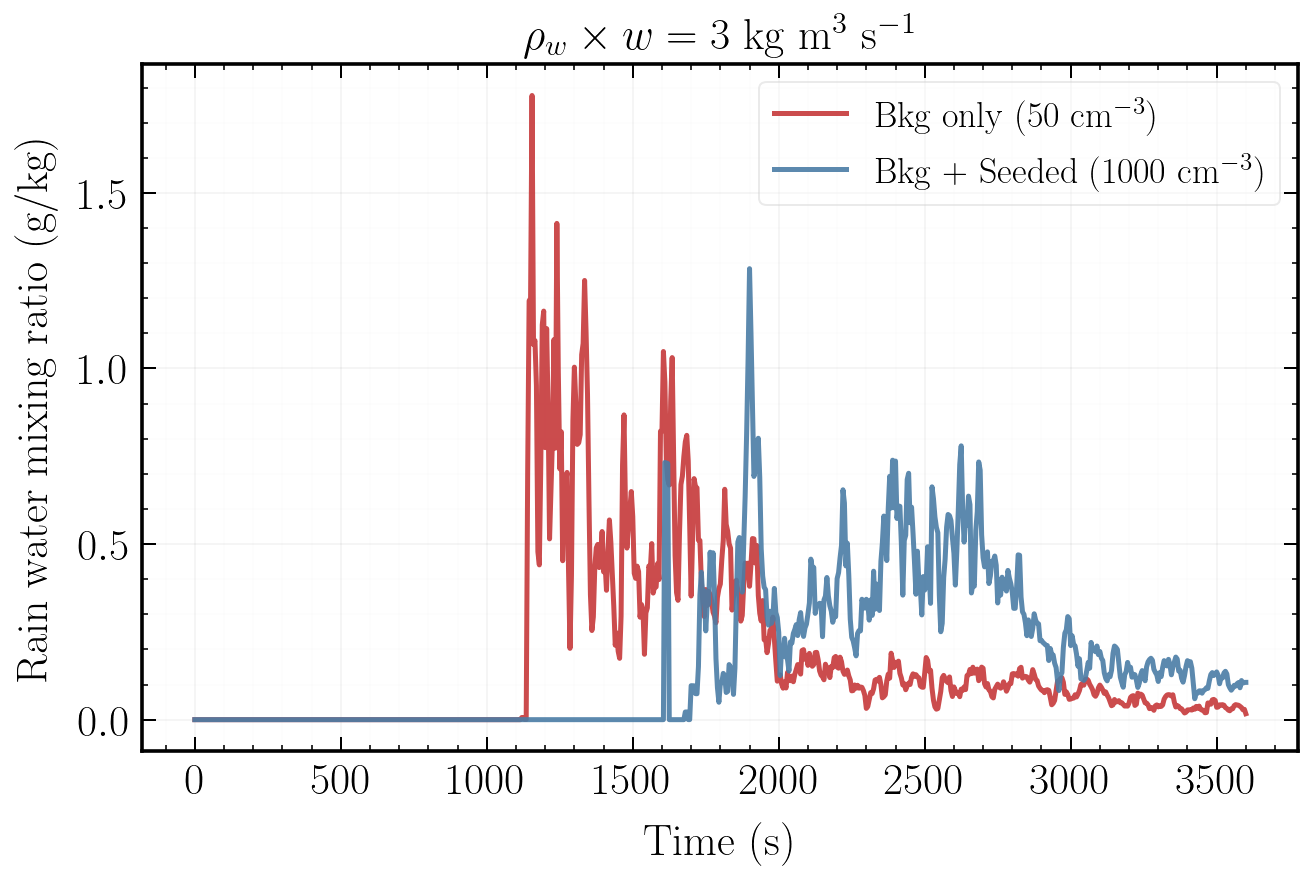

In [14]:
fig, ax= plt.subplots(1, 1, figsize= (9, 6) , constrained_layout= True)

ax.plot(rain_xarr_rhow3_bkg['t'], rain_xarr_rhow3_bkg.sel(z= 25).values, label= r'Bkg only (50 cm$^{-3}$)')
ax.plot(rain_xarr_rhow3_seed['t'], rain_xarr_rhow3_seed_high.sel(z= 25).values, label= r'Bkg + Seeded (1000 cm$^{-3}$)')
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Rain water mixing ratio (g/kg)', fontsize= 22);
ax.legend(frameon= True, fontsize= 18);

ax.set_title(r'$\rho_w \times w = 3$ kg m$^{3}$ s$^{-1}$', fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.savefig('../../plots/rwmr_rhow=3.0_n1_50_n2_1000.pdf', bbox_inches='tight', dpi= 300);

## Sanity check

In [12]:
simulation["rhow=2.0_p=True"].attributes

{'dry volume': array([2.95393123e-25, 3.80275071e-25, 4.33283289e-25, ...,
        1.77184570e-21, 1.90167124e-21, 2.18060169e-21]),
 'kappa times dry volume': array([1.59512286e-25, 2.05348538e-25, 2.33972976e-25, ...,
        1.50606885e-21, 1.61642055e-21, 1.85351144e-21]),
 'multiplicity': array([22234235, 19113730, 21921922, ..., 41417959, 41088767, 44468469]),
 'cell id': array([ 7, 42, 42, ..., 11, 28, 31]),
 'cell origin': array([[ 7, 42, 42, ..., 11, 28, 31]]),
 'position in cell': array([[0.04679442, 0.66643869, 0.90300366, ..., 0.9795265 , 0.11254069,
         0.15216944]]),
 'water mass': array([3.54077126e-22, 5.17493711e-22, 6.06810218e-22, ...,
        6.84346755e-18, 8.98395802e-16, 1.19509775e-16])}

In [21]:
simulation= Simulation(settings["rhow=2.0_p=True"])
output= simulation.run().products

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [29]:
simulation.attributes

{'dry volume': array([2.95393123e-25, 3.80275071e-25, 4.33283289e-25, ...,
        1.77184570e-21, 1.90167124e-21, 2.18060169e-21]),
 'kappa times dry volume': array([1.59512286e-25, 2.05348538e-25, 2.33972976e-25, ...,
        1.50606885e-21, 1.61642055e-21, 1.85351144e-21]),
 'multiplicity': array([17483097, 18506221, 20380936, ..., 44468469, 36123211, 44468469]),
 'cell id': array([ 7, 42, 42, ..., 11, 28, 31]),
 'cell origin': array([[ 7, 42, 42, ..., 11, 28, 31]]),
 'position in cell': array([[0.04679442, 0.66643869, 0.90300366, ..., 0.9795265 , 0.11254069,
         0.15216944]]),
 'water mass': array([3.54077126e-22, 5.17493711e-22, 6.06810218e-22, ...,
        6.84346755e-18, 8.98395802e-16, 1.19509775e-16])}